## Helping Scotland Towns to a better and cheaper energy performance future

### Background
The issue of the steep rise in cost of living has been at the first and foremost of minds of all citizens, especially so now that winter is upon us and fuel costs to stay warm will be at a all-time high. The local authorities are doing the best they can to assist. Some of the local government initiatives include extending energy advice to businesses via Business Energy Scotland, and also the Winter Heating Payment allowance to low income households, in order to combat the issue aforementioned.
<br><br>
Through an analysis of the energy performance data used in the production of Energy Performance Certificates in Scotland, we hope to identify the key insights why some towns or buildings seemed to have better energy efficiency and are better at cutting energy costs. We will also propose a basic recommender model where using given roof and wall materials, the recommender model can make suggestions on what wall or roof improvements can be made for better energy efficiency. We will also look at what are the building factors that could contribute to the total cost of energy, and how one's costs can be lowered if switch to other materials instead. The information can be shared to others in making improvements to their buildings for reduction in fuel costs and lower emissions.  

In [1]:
# Pandas 1.3.1 required to run df.explode
# !pip3 install --upgrade pandas

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# for search keywords matching and permutations
from difflib import SequenceMatcher, get_close_matches
from itertools import permutations

In [4]:
#ML preprocessing lib
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

#ML model lib
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV

In [5]:
df = pd.read_csv(r'./data/Scotland EPC Dataset.csv')
# df.shape

In [6]:
# df.describe()

In [7]:
#reformat columns to lowercase and replace space with underscore
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()

In [8]:
# df.info()

In [9]:
# -------------------------------- Data Cleaning---------------------------- #

In [10]:
# object_cols = df.select_dtypes(include='object').columns.tolist()
# object_cols

In [11]:
cleanup_cols = ['post_town', 'wall_energy_eff', 'roof_energy_eff', 'floor_energy_eff', 'floor_env_eff',\
               'windows_energy_eff', 'windows_env_eff', 'mainheat_energy_eff', 'mainheat_env_eff', \
                'mainheatc_energy_eff','mainheatc_env_eff', 'hot_water_energy_eff', 'hot_water_env_eff', \
                'lighting_energy_eff', 'lighting_env_eff', 'built_form', 'property_type']
for col in cleanup_cols:
    df[col] = df[col].str.lower()
    df[col] = df[col].str.strip()
    

In [12]:
trim_cols = ['wall_description','roof_description','floor_description','windows_description',\
             'mainheat_description','mainheatcont_description','lighting_description','part_1_construction_age_band']
for col in trim_cols:
    df[col] = df[col].str.strip()


In [13]:
# fill NaN values
df['part_1_construction_age_band'].fillna("others", inplace=True)
df['built_form'].fillna("others", inplace=True)

In [14]:
# clean up town names
df.loc[ df['post_town'] == 'acharcle', 'post_town'] = 'acharacle'
df.loc[ df['post_town'] == 'argyll &amp; bute', 'post_town'] = 'argyll and bute'
df.loc[ df['post_town'] == "bo'ness", 'post_town'] = 'bo\'ness'
df.loc[ df['post_town'] == 'campbe;town', 'post_town'] = 'campbeltown'
df.loc[ df['post_town'] == 'caslte douglas', 'post_town'] = 'castle douglas'
df.loc[ df['post_town'] == 'crianlarich', 'post_town'] = 'crainlarich'
df.loc[ df['post_town'] == 'dairy', 'post_town'] = 'dalry'     
df.loc[ df['post_town'] == 'edingburgh', 'post_town'] = 'edinburgh'
df.loc[ df['post_town'] == 'granton on spey', 'post_town'] = 'grantown-on-spey'
df.loc[ df['post_town'] == 'granton-on-spey', 'post_town'] = 'grantown-on-spey'
df.loc[ df['post_town'] == 'grantown on spey', 'post_town'] = 'grantown-on-spey'
df.loc[ df['post_town'] == 'invergodon', 'post_town'] = 'invergordon'
df.loc[ df['post_town'] == 'johnston', 'post_town'] = 'johnstone'
df.loc[ df['post_town'] == 'malaig', 'post_town'] = 'mallaig'
df.loc[ df['post_town'] == 'newport on tay', 'post_town'] = 'newport-on-tay'
df.loc[ df['post_town'] == 'newton merans', 'post_town'] = 'newton mearns'
df.loc[ df['post_town'] == 'newton st boswells', 'post_town'] = 'newtown st boswells'
df.loc[ df['post_town'] == 'newtown st boswell', 'post_town'] = 'newtown st boswells'
df.loc[ df['post_town'] == 'north aryshire', 'post_town'] = 'north ayrshire'
df.loc[ df['post_town'] == 'perth &amp; kinross', 'post_town'] = 'perth and kinross'
df.loc[ df['post_town'] == 'roy bridge', 'post_town'] = 'roybridge'
df.loc[ df['post_town'] == 'stornaway', 'post_town'] = 'stornoway'

In [15]:
# clean up metric in wall_description, roof_description
df['wall_description'] = df['wall_description'].str.replace('W/m?K', 'W/m²K', regex=False)
df['wall_description'] = df['wall_description'].str.replace('W/mÂ²K', 'W/m²K', regex=True)

df['roof_description'] = df['roof_description'].str.replace('W/m?K', 'W/m²K', regex=False)
df['roof_description'] = df['roof_description'].str.replace('W/mÂ²K', 'W/m²K', regex=True)

# clean up 'n/a' in roof_energy_eff
df['roof_energy_eff'] = df['roof_energy_eff'].replace('n/a', np.nan)

# df['wall_description'].sort_values().unique()

### Overview on the energy performance in Scotland by towns

Here we provide a Top 10 list of local towns ranked by the following criterias: <br>
<ul>
 <li>Towns by current efficiency rating </li>
    <li>Towns by potential energy efficiency rating </li>
    <li>Towns by current environmental impact rating and note if there have been periods where houses were more or less environmentally friendly</li>
    <li>Towns by potential environmental impact rating </li>
    <li>Towns by Current Emissions (T.CO2/yr) </li>
    <li>Towns by Potential Reduction in Emissions (T.CO2/yr) </li>
    <li>Towns by potential savings in heating costs (£) over three years </li>
    <li>Towns by potential savings in hot water costs (£) over three years </li>
    </ul>

For reference, these ratings are based on the following scale:
<ul>
 <li> Current efficiency rating: higher ratings indicate better efficiency. </li>
    <li> Potential energy efficiency rating: higher ratings indicate better efficiency. </li>
    <li> Current environmental impact rating: higher ratings indicate better environmental impact.</li>
    <li> Potential environmental impact rating: higher ratings indicate better environmental impact. </li>
    <li> Current Emissions (T.CO2/yr): higher ratings indicate lower emissions.  </li>
    <li> Potential Reduction in Emissions (T.CO2/yr): higher ratings indicate higher potential reductions. </li>
    <li> Potential savings in heating costs (£) over three years: Calculated from current heating costs (£) over three years - potential heating costs (£) over three years. Higher numbers indicate more savings in costs.   </li>
    <li> Potential savings in hot water costs (£) over three years: Calculated from current hot water costs (£) over three years - potential how water costs (£) over three years. Higher numbers indicate more savings in costs. </li>
    </ul>

<b>Note:</b> Some of these rankings may show more than 10 towns since there are some towns tied at the same position 

In [16]:
# ------------------------ Rank & Plot Top 10 Towns ranked by various criterias ---------------------------- #

In [17]:
# calculate potential savings for heating costs and hot water costs
df['potential_savings_in_heating_costs_over_3_years'] = df['current_heating_costs_over_3_years_(£)'] -\
                                                            df['potential_heating_costs_over_3_years_(£)']

df['potential_savings_in_hot_water_costs_over_3_years']= df['current_hot_water_costs_over_3_years_(£)']- \
                                                            df['potential_hot_water_costs_over_3_years_(£)']

In [18]:
# create a separate dataframe to contain rankings

rank_cols = ['post_town', 'current_energy_efficiency_rating', 'potential_energy_efficiency_rating',
            'current_environmental_impact_rating', 'part_1_construction_age_band',
            'potential_environmental_impact_rating', 'current_emissions_(t.co2/yr)',
            'potential_reduction_in_emissions_(t.co2/yr)', 'current_heating_costs_over_3_years_(£)', 
            'potential_heating_costs_over_3_years_(£)', 'current_hot_water_costs_over_3_years_(£)',
            'potential_hot_water_costs_over_3_years_(£)', 'potential_savings_in_heating_costs_over_3_years',
             'potential_savings_in_hot_water_costs_over_3_years']
df_rank = df[rank_cols].copy()

In [19]:
# calculate average for use of rankings

# nested list for group averaging: [[cols to filter], [groupby cols], [averaging col]]
rank_curr_energy = [['post_town', 'current_energy_efficiency_rating'], ['post_town'], \
                    ['current_energy_efficiency_rating']]
rank_potential_energy = [['post_town', 'potential_energy_efficiency_rating'], ['post_town'], \
                         ['potential_energy_efficiency_rating']]
rank_curr_impact = [['post_town', 'current_environmental_impact_rating', 'part_1_construction_age_band'], \
                    ['post_town', 'part_1_construction_age_band'],['current_environmental_impact_rating']]
rank_potential_impact = [['post_town', 'potential_environmental_impact_rating'], \
                        ['post_town'],['potential_environmental_impact_rating']]
rank_curr_emissions = [['post_town', 'current_emissions_(t.co2/yr)'], \
                        ['post_town'],['current_emissions_(t.co2/yr)']]
rank_potential_reductions = [['post_town', 'potential_reduction_in_emissions_(t.co2/yr)'], \
                             ['post_town'],['potential_reduction_in_emissions_(t.co2/yr)']]
rank_savings_heating = [['post_town', 'potential_savings_in_heating_costs_over_3_years'], \
                        ['post_town'],['potential_savings_in_heating_costs_over_3_years']]
rank_savings_hotwater = [['post_town', 'potential_savings_in_hot_water_costs_over_3_years'], \
                         ['post_town'],['potential_savings_in_hot_water_costs_over_3_years']]

def group_average(group):
    average = 'average_' + str(group[2][0])
    df_rank[average] = df_rank[group[0]].groupby(group[1])[group[2]].transform('mean')

In [20]:
# generate average for each group
group_average(rank_curr_energy)
group_average(rank_potential_energy)
group_average(rank_curr_impact)
group_average(rank_potential_impact)
group_average(rank_curr_emissions)
group_average(rank_potential_reductions)
group_average(rank_savings_heating)
group_average(rank_savings_hotwater)

In [21]:
# generate rankings
def ranking(col, order=True):
    rank_field = 'rank_' + col
    df_rank[rank_field] = df_rank[col].rank(method = 'dense', ascending=order)

In [22]:
# generate rankings for each group
ascending_cols = ['average_current_emissions_(t.co2/yr)']

descending_cols = ['average_current_energy_efficiency_rating',\
                  'average_potential_energy_efficiency_rating',\
                  'average_current_environmental_impact_rating',\
                  'average_potential_environmental_impact_rating',\
                   'average_potential_reduction_in_emissions_(t.co2/yr)',\
                   'average_potential_savings_in_heating_costs_over_3_years',\
                  'average_potential_savings_in_hot_water_costs_over_3_years']

for c in ascending_cols:
    ranking(c)
    
for d in descending_cols:
    ranking(d, False)

In [23]:
def plot_ranking(x, y):
    df_rank_filter = df_rank[[x,y,'post_town']].drop_duplicates()
    sorted_rank = df_rank_filter[df_rank_filter[x] <= 10].sort_values(by=x)
    
    f, ax = plt.subplots(figsize = (8, 6))
    sns.barplot(x='post_town', y=y, data = sorted_rank)
    
    ylabel = y.replace('_', ' ')
    title = 'Top 10 Towns by ' + ylabel + ' from 1st to 10th'
    
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Post Town')
    plt.ylabel(ylabel)
    plt.show()

In [24]:
sns.set_style("whitegrid")
sns.set(font_scale=1.25)

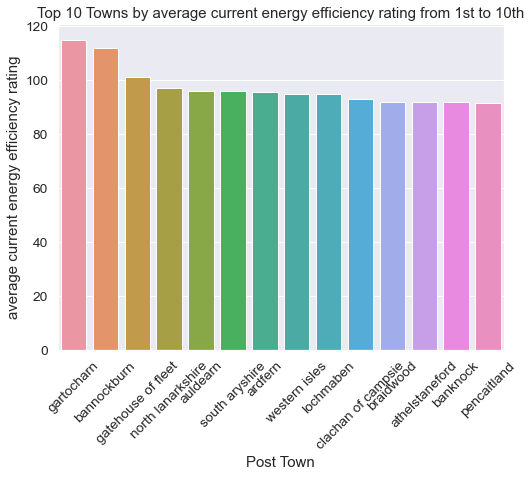

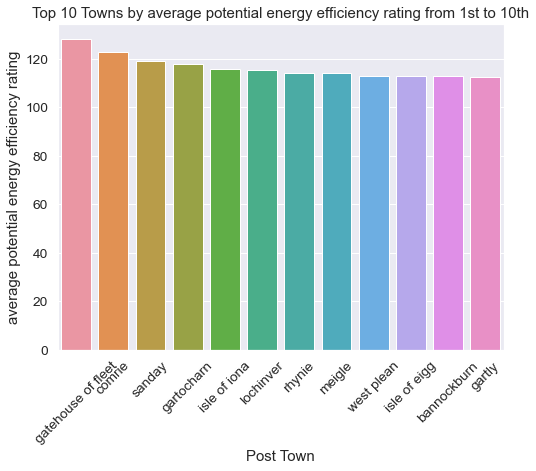

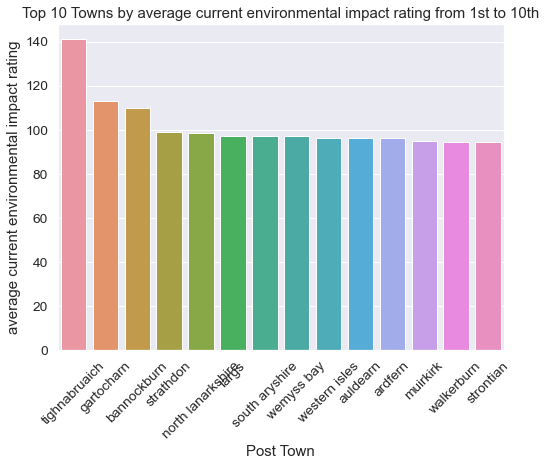

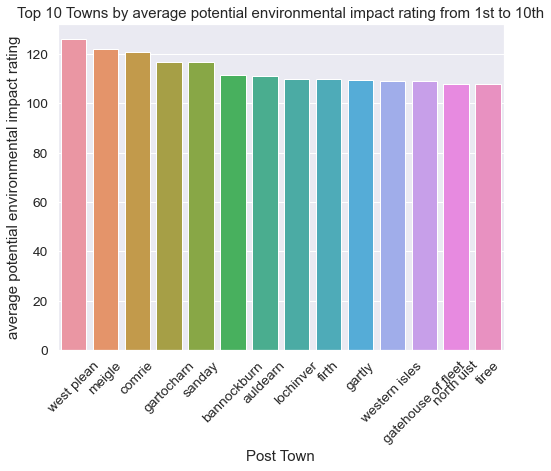

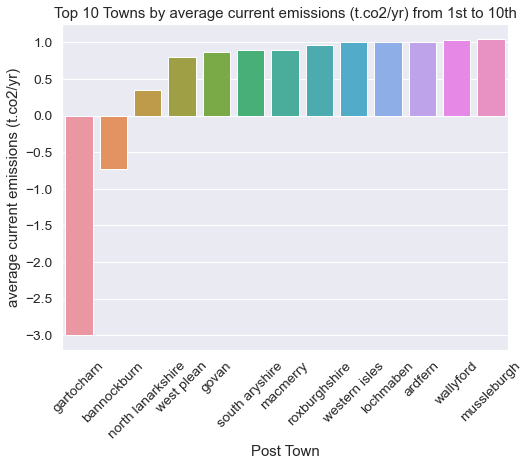

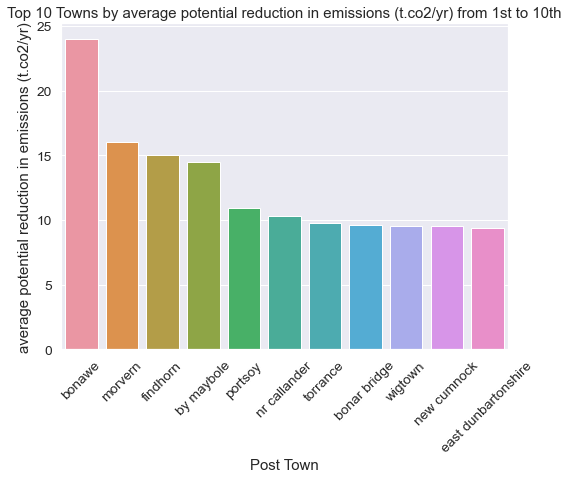

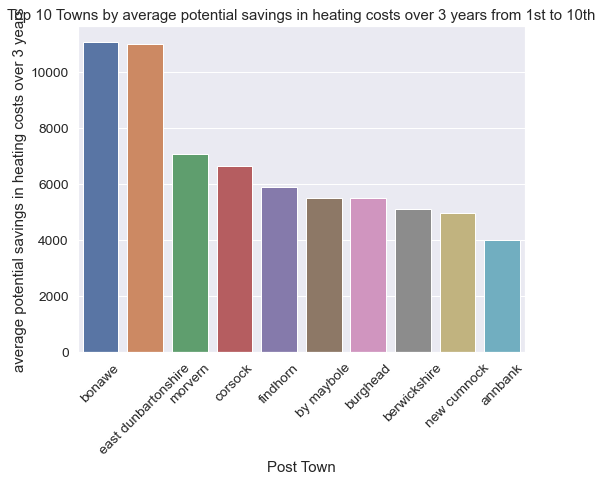

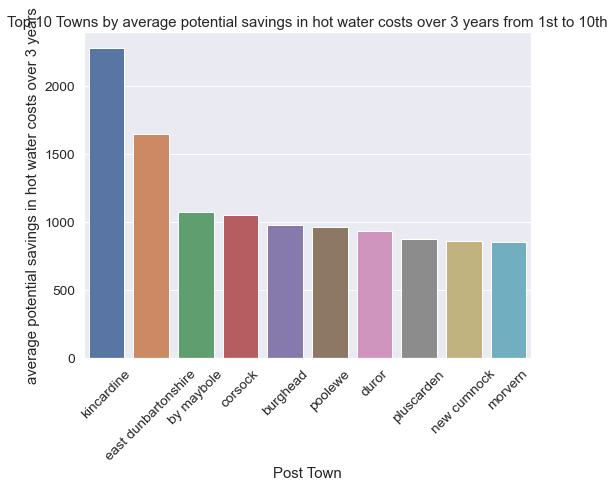

In [25]:
average_cols = [c for c in df_rank.columns if c.startswith('average')]

for c in average_cols:
    plot_ranking('rank_'+str(c) , c)


In [26]:
rank_cols = [c for c in df_rank.columns if c.startswith('rank_') or c.startswith('average_')]
rank_cols.insert(0, 'post_town')
rank_cols.insert(1, 'part_1_construction_age_band')
df_rank_output = df_rank[rank_cols].drop_duplicates()

In [27]:
df_rank_output.to_csv (r'./data/scotland_town_energy_performance_rankings.csv', index = None, header=True) 

### <u> Correlations Analysis </u>

<br>
We dive further into analysing some of the building characteristics that may be correlated with the energy performance data, in particular,
<ul>
<li>Correlations between CO2 emissions current per floor area vs wall description and wall energy efficiency</li><li>Correlations between CO2 emissions current per floor area vs roof description and roof energy efficiency </li>
<li>Correlations between construction age band vs current energy efficiency and current emissions (T.CO2/yr)</li> 
</ul>

### Correlations between CO2 emissions current per floor area vs wall description and wall energy efficiency

In [28]:
df_wall = df[['co2_emissions_current_per_floor_area_(kg.co2/m²/yr)', 'wall_description', 'wall_energy_eff']].copy()

In [29]:
# split multiple wall descriptions and efficiency ratings into separate records

df_wall['wall_description'] = df_wall['wall_description'].str.split("|")
df_wall['wall_energy_eff'] = df_wall['wall_energy_eff'].str.split("|")

df_wall = df_wall.explode(['wall_description', 'wall_energy_eff'])

df_wall['wall_energy_eff'] = df_wall['wall_energy_eff'].str.strip()
df_wall['wall_description'] = df_wall['wall_description'].str.strip()

In [30]:
# map wall efficiency ratings from alphanumeric values to numeric values

dict_efficiency = {'very poor':1, 'poor':2, 'average':3, 'good':4, 'very good':5}
df_wall['wall_energy_eff'] = df_wall['wall_energy_eff'].map(dict_efficiency)

In [31]:
def wall_average(group):
    average = 'average_' + str(group[2][0])
    df_wall[average] = df_wall[group[0]].groupby(group[1])[group[2]].transform('mean')

rank_wall_energy_eff = [['wall_description', 'wall_energy_eff'], ['wall_description'], ['wall_energy_eff']]
wall_average(rank_wall_energy_eff)

rank_co2_emission = [['wall_description','co2_emissions_current_per_floor_area_(kg.co2/m²/yr)'], \
                     ['wall_description'], ['co2_emissions_current_per_floor_area_(kg.co2/m²/yr)']]
wall_average(rank_co2_emission)

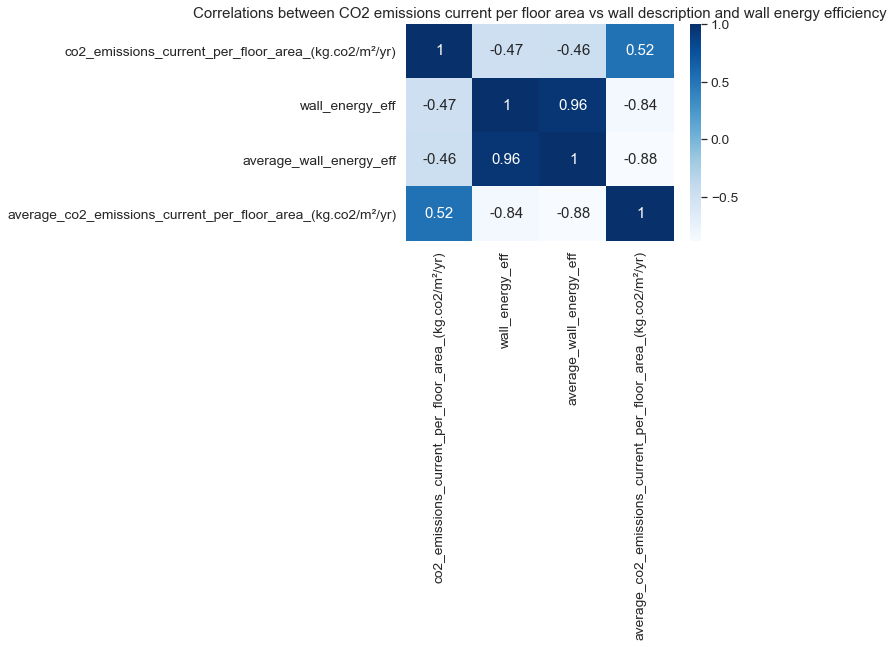

In [32]:
# calculate the correlation

corr = df_wall.corr(numeric_only=True)
# plot the heatmap
sns.heatmap(corr, cmap='Blues', annot=True)
plt.title("Correlations between CO2 emissions current per floor area vs wall description and wall energy efficiency")
plt.show()

### <u>Findings</u>

As a guide, the numbers above are in the scale from -1 to 1, where negative numbers indicate negative correlations  and likewise for positive numbers. The strength of correlations are measured by how close these numbers are towards -1 (strong negative correlation) and 1 (strong positive correlation).
<br><br>
The correlation matrix above shows that:<br>
<ol>
    <li>Co2 emissions current per floor area decrease when the wall energy efficiency ratings increase, indicating a moderately negative correlation. </li>
    <li>The wall energy efficiency ratings and its average ratings are strongly positively correlated.</li>
    <li>The co2 emissions current per floor area and its average re moderately positively correlated.</li>

To create a single rating combining CO2 emissions and wall energy efficiency, first:
<ol>
    <li> Rank the average CO2 emissions current per floor area, where lower emissions will be ranked higher (1 - Best).</li>
    <li> Rank the average wall energy efficiency rating, where higher efficiency will be ranked higher.</li>
</ol>
The ranks generated from (1) and (2) are then combined for a single rating across all wall materials.
<br>

In [33]:
# --------------- Algo. to find correlations between CO2 emissions current per floor area ------------ # 
#------------------------- vs wall description and wall energy efficiency ---------------------------- #

In [34]:
# generate rankings
def wall_ranking(col, order=True):
    rank_field = 'rank_' + col
    df_wall[rank_field] = df_wall[col].rank(method = 'dense', ascending=order)

#generate individual rankings for wall materials v.s. CO2, wall materials v.s. wall energy efficiency
ind_wall_ranking = ['average_co2_emissions_current_per_floor_area_(kg.co2/m²/yr)', 'average_wall_energy_eff']
wall_ranking(ind_wall_ranking[0])
wall_ranking(ind_wall_ranking[1], False)

# generate overall rating for each wall material
wall_ranks = [c for c in df_wall if c.startswith('rank')]
df_wall['rank_wall_overall'] = df_wall[wall_ranks].apply(tuple,axis=1).rank(method='dense').astype(int)

<u> Top 5 wall materials by CO2 emissions current per floor area and wall energy efficiency </u>

In [35]:
wall_filter = ['wall_description', 'rank_wall_overall', 'average_wall_energy_eff', \
               'average_co2_emissions_current_per_floor_area_(kg.co2/m²/yr)']

df_wall_filter = df_wall[wall_filter].drop_duplicates().reset_index(drop=True)
df_wall_filter.dropna(inplace=True)

# print("Top 5 wall descriptions (wall materials) by CO2 emissions current per floor area and wall energy efficiency\n")
df_wall_filter_5 = df_wall_filter[df_wall_filter['rank_wall_overall'] <= 5].sort_values(by='rank_wall_overall')
df_wall_filter_5[['rank_wall_overall', 'wall_description']]

,rank_wall_overall,wall_description
89,1,Average thermal transmittance 0.09 W/m²K
29,2,Average thermal transmittance 0.14 W/m²K
67,3,Average thermal transmittance 0.10 W/m²K
37,4,Average thermal transmittance 0.17 W/m²K
44,5,Average thermal transmittance 0.11 W/m²K


In [36]:
df_wall_filter.to_csv (r'./data/scotland_town_wall_material_rankings.csv', index = None, header=True) 

### Correlations between CO2 emissions current per floor area vs roof description and roof energy efficiency

In [37]:
df_roof = df[['co2_emissions_current_per_floor_area_(kg.co2/m²/yr)', 'roof_description', 'roof_energy_eff']].copy()

In [38]:
df_roof.dropna(inplace=True)

In [39]:
# split multiple roof descriptions and efficiency ratings into separate records

df_roof['roof_description'] = df_roof['roof_description'].str.split("|")
df_roof['roof_energy_eff'] = df_roof['roof_energy_eff'].str.split("|")

df_roof = df_roof.explode(['roof_description', 'roof_energy_eff'])

df_roof['roof_energy_eff'] = df_roof['roof_energy_eff'].str.strip()
df_roof['roof_description'] = df_roof['roof_description'].str.strip()

In [40]:
# map roof efficiency ratings from alphanumeric values to numeric values

df_roof['roof_energy_eff'] = df_roof['roof_energy_eff'].map(dict_efficiency)

In [41]:
def roof_average(group):
    average = 'average_' + str(group[2][0])
    df_roof[average] = df_roof[group[0]].groupby(group[1])[group[2]].transform('mean')

rank_roof_energy_eff = [['roof_description', 'roof_energy_eff'], ['roof_description'], ['roof_energy_eff']]
roof_average(rank_roof_energy_eff)

rank_co2_emission = [['roof_description','co2_emissions_current_per_floor_area_(kg.co2/m²/yr)'], \
                     ['roof_description'], ['co2_emissions_current_per_floor_area_(kg.co2/m²/yr)']]
roof_average(rank_co2_emission)

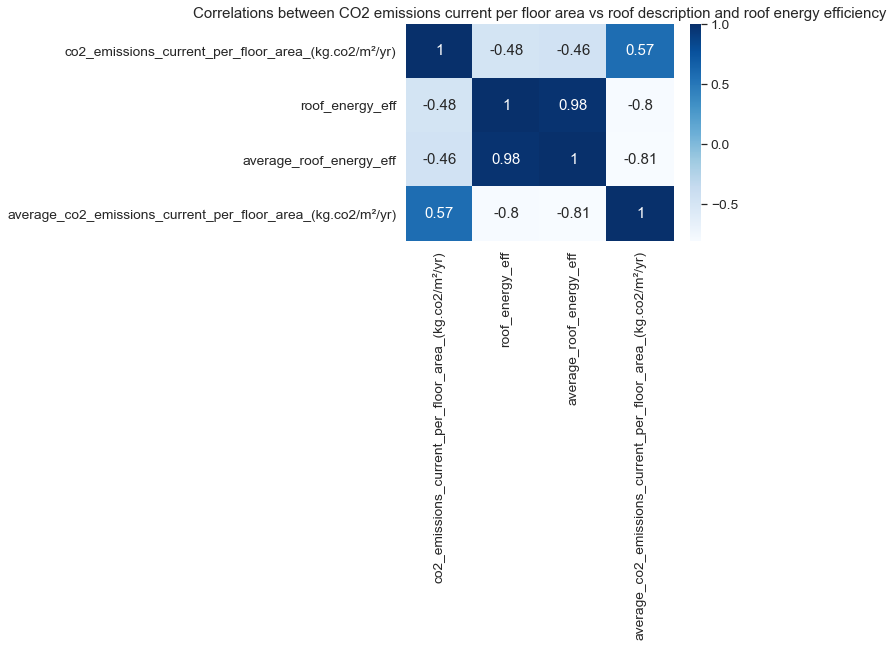

In [42]:
# calculate the correlation

corr = df_roof.corr(numeric_only=True)
# plot the heatmap
sns.heatmap(corr, cmap='Blues', annot=True)
plt.title("Correlations between CO2 emissions current per floor area vs roof description and roof energy efficiency")
plt.show()

The correlation matrix above shows that:
<ol>
    <li>Co2 emissions current per floor area decrease when the roof energy efficiency ratings increase, indicating a moderately negative correlation.</li>
    <li>The roof energy efficiency ratings and its average ratings are strongly correlated.</li>
    <li>The co2 emissions current per floor area and its average are moderately positively correlated.</li>
</ol>

To create a single rating combining CO2 emissions and roof energy efficiency, first:
<ol>
    <li>Rank the average CO2 emissions current per floor area where lower emissions will be ranked higher (1 - Best).</li>
    <li>Rank the average roof energy efficiency rating when higher efficiency will be ranked higher.</li>
</ol>
Ranks from (1) and (2) are then combined for a single rating across all roof materials.

In [43]:
# --------------- Algo. to find correlations between CO2 emissions current per floor area ------------ # 
#------------------------- vs roof description and roof energy efficiency ---------------------------- #

In [44]:
# generate rankings
def roof_ranking(col, order=True):
    rank_field = 'rank_' + col
    df_roof[rank_field] = df_roof[col].rank(method = 'dense', ascending=order)

#generate individual rankings for roof materials v.s. CO2, roof materials v.s. roof energy efficiency
ind_roof_ranking = ['average_co2_emissions_current_per_floor_area_(kg.co2/m²/yr)', 'average_roof_energy_eff']
roof_ranking(ind_roof_ranking[0])
roof_ranking(ind_roof_ranking[1], False)

# generate overall rating for each roof material
roof_ranks = [c for c in df_roof if c.startswith('rank')]
df_roof['rank_roof_overall'] = df_roof[roof_ranks].apply(tuple,axis=1).rank(method='dense').astype(int)

Top 5 roof descriptions by CO2 emissions current per floor area and wall energy efficiency

In [45]:
roof_filter = ['roof_description', 'rank_roof_overall', 'average_roof_energy_eff', \
               'average_co2_emissions_current_per_floor_area_(kg.co2/m²/yr)']

df_roof_filter = df_roof[roof_filter].drop_duplicates().reset_index(drop=True)
df_roof_filter.dropna(inplace=True)

# print("Top 5 roof descriptions by CO2 emissions current per floor area and wall energy efficiency")
df_roof_filter_5 = df_roof_filter[df_roof_filter['rank_roof_overall'] <= 5].sort_values(by='rank_roof_overall')
df_roof_filter_5[['rank_roof_overall', 'roof_description']]

,rank_roof_overall,roof_description
59,1,Average thermal transmittance 0.06 W/m²K
16,2,Average thermal transmittance 0.11 W/m²K
39,3,Average thermal transmittance 0.08 W/m²K
38,4,Average thermal transmittance 0.09 W/m²K
15,5,Average thermal transmittance 0.10 W/m²K


In [46]:
df_roof_filter.to_csv (r'./data/scotland_town_roof_material_rankings.csv', index = None, header=True) 

### Correlations between construction age band vs current energy efficiency and current emissions (T.CO2/yr)

In [47]:
df_construction = df[['current_energy_efficiency_rating', 'part_1_construction_age_band',\
                     'current_emissions_(t.co2/yr)']].copy()

In [48]:
def construction_average(group):
    average = 'average_' + str(group[2][0])
    df_construction[average] = df_construction[group[0]].groupby(group[1])[group[2]].transform('mean')

rank_construction_energy_eff = [['current_energy_efficiency_rating', 'part_1_construction_age_band'],\
                      ['part_1_construction_age_band'],['current_energy_efficiency_rating']]
construction_average(rank_construction_energy_eff)

rank_current_emissions = [['part_1_construction_age_band','current_emissions_(t.co2/yr)'], \
                          ['part_1_construction_age_band'],['current_emissions_(t.co2/yr)']]
construction_average(rank_current_emissions)

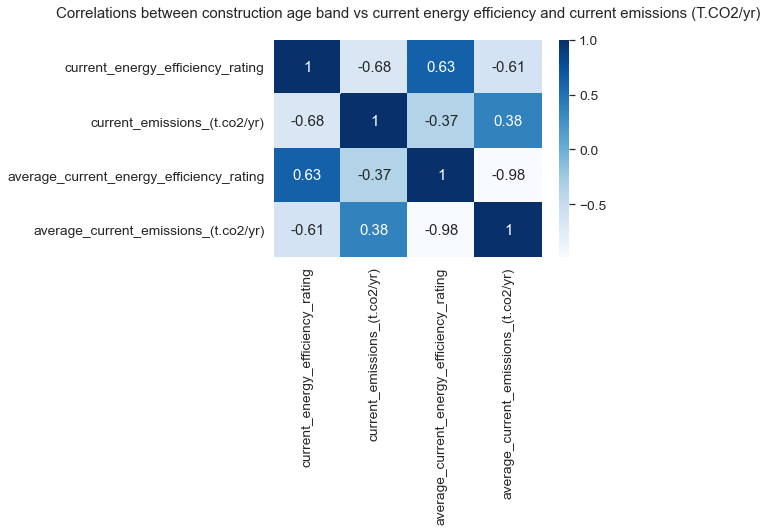

In [49]:
# calculate the correlation

corr = df_construction.corr(numeric_only=True)
# plot the heatmap
sns.heatmap(corr, cmap='Blues', annot=True)
plt.title("Correlations between construction age band vs current energy efficiency and current emissions (T.CO2/yr)\n")
plt.show()

The correlation matrix above shows that:
<ol>
    <li>Current emissions (t.co2/yr) decrease when the current energy efficiency rating increase, indicating a moderately negative correlation. </li>
    <li>The average current emissions (t.co2/yr) and the average current energy efficiency rating are strongly negatively correlated.</li>
    <li>The current emissions (t.co2/yr) and its average are moderately positively correlated.</li>
    <li>The current energy efficiency rating and its average are moderately positively correlated.</li>
</ol>

We're interested to see how the construction's age would relate to the current emissions (t.co2/yr) plus current energy efficiency rating. To do so, we adopt a single rating combining current emissions(t.co2/yr) plus current energy efficiency rating. First:
<ol>
    <li> Rank the average current emissions(t.co2/yr) where lower emissions will be ranked higher (1 - Best).</li>
    <li> Rank the average current energy efficiency rating when higher efficiency will be ranked higher.</li>
</ol>
Results from (1) and (2) are then combined for a single rating for the construction age band.

In [50]:
# --------------- Algo. to find correlations between construction age band ------------------------------- # 
#----------------- current energy efficiency and current emissions (T.CO2/yr) ---------------------------- #

In [51]:
# generate rankings
def construction_ranking(col, order=True):
    rank_field = 'rank_' + col
    df_construction[rank_field] = df_construction[col].rank(method = 'dense', ascending=order)

# generate individual rankings for construction age band v.s. current emissions, 
# construction age band v.s. current energy efficiency
ind_construction_ranking = ['average_current_emissions_(t.co2/yr)', 'average_current_energy_efficiency_rating']
construction_ranking(ind_construction_ranking[0])
construction_ranking(ind_construction_ranking[1], False)

# generate overall rating for each construction age band
construction_ranks = [c for c in df_construction if c.startswith('rank')]
df_construction['rank_construction_overall'] = df_construction[construction_ranks].apply(tuple,axis=1).rank(method='dense').astype(int)

<u> Construction age band vs Current energy efficiency and Current emissions (t.co2/yr) </u>

In [52]:
construction_filter = ['part_1_construction_age_band', 'rank_construction_overall', \
                       'rank_average_current_energy_efficiency_rating', \
                     'rank_average_current_emissions_(t.co2/yr)', ]

df_construction_filter = df_construction[construction_filter].drop_duplicates().reset_index(drop=True)
# print("Correlations between construction age band vs current energy efficiency and current emissions")
df_construction_filter_rank = df_construction_filter.sort_values(by='rank_construction_overall')
df_construction_filter_rank[['rank_construction_overall', 'part_1_construction_age_band' ]]

,rank_construction_overall,part_1_construction_age_band
11,1,others
8,2,2008 onwards
9,3,2003-2007
3,4,1999-2002
10,5,1992-1998
7,6,1984-1991
5,7,1976-1983
6,8,1950-1964
2,9,1965-1975
0,10,1930-1949


In [53]:
df_construction_filter.to_csv (r'./data/scotland_town_construction_age_rankings.csv', index = None, header=True) 

We conclude that the construction age band is strongly correlated to a higher energy efficiency rating and lower emissions overall, where new-builts are more energy efficient as compared to older-builts.

## Recommender model for wall and roof materials

Using characteristics of a wall/roof as input, the recommender model identifies the closest match in the data and recommends a list of more energy efficient suggestions. With this, users could consider their options available in improving the energy efficiency of their building and save on fuel costs over time.

In [54]:
# --------------- Algo. takes as input the characteristics of a building ------------------------------- # 
#----------- outputs recommendations on the elements to be modified to improve energy performance ------ #

In [55]:
# extract all unique wall and roof materials as search patterns for input matching

wall_patterns = df_wall_filter['wall_description'].str.replace(',', '').str.lower().unique()
roof_patterns = df_roof_filter['roof_description'].str.replace(',', '').str.lower().unique()

In [56]:
# process search phrase: to lowercase, replace all special char, generate all possible combinations of search 
# phrases with given input

def process_search(search_phrase):
    search_phrase = search_phrase.lower()
    search_phrase = re.sub('[^a-z0-9 ]+', ' ', search_phrase)

    # Stores all words in the sentence
    lis = list(search_phrase.split())
 
    # Stores all possible permutations of words in this list
    permute = permutations(lis) 
    
    # Iterate over all permutations
    search_list = []
    for i in permute:       
        # Convert the current permutation into a list and join into new phrase
        permutelist = list(i)
        phrase = ' '.join(permutelist)
        search_list.append(phrase)
    return search_list    

# find closest match using given input

def closeMatches(patterns, search_phrase):
    #clean up input and generate all possible combos of input
    search_list = process_search(search_phrase)
    best_match_array = []
    best_score_array = []
    
    #find the best match from list
    for s in search_list:
        match_list = get_close_matches(s, patterns, cutoff=0.4)
        if len(match_list) > 0:
            best_match = match_list[0]
            best_match_array.append(best_match)
            score = SequenceMatcher(None, s, best_match).ratio()
            best_score_array.append(score)

    if len(best_score_array) > 0:
        overall_best_score = np.argmax(np.array(best_score_array))
        return best_match_array[overall_best_score]
    else:
        return False


In [57]:
def recommend_wall(search):
    print("Closest match result:", search)
    #remove commas and to lowercase to match with search phrase
    df_wall_filter.reset_index()
    df_wall_filter['wall_description'] = df_wall_filter['wall_description'].str.replace(',', '').str.lower()
    
    result_wall_energy_eff = df_wall_filter.loc[df_wall_filter['wall_description'].str.contains(search, regex=False), \
                               'average_wall_energy_eff'].values[0]
    print("Average wall energy efficiency for " + search + ": " + str(result_wall_energy_eff))
  
    recc = df_wall_filter[df_wall_filter['average_wall_energy_eff'] >= result_wall_energy_eff]
    return recc

In [58]:
def recommend_roof(search):
    print("Closest match result:", search)
    #remove commas and to lowercase to match with search phrase
    df_roof_filter.reset_index()
    df_roof_filter['roof_description'] = df_roof_filter['roof_description'].str.replace(',', '').str.lower()
    
    result_roof_energy_eff = df_roof_filter.loc[df_roof_filter['roof_description'].str.contains(search, regex=False), \
                               'average_roof_energy_eff'].values[0]
    print("Average roof energy efficiency for " + search + ": " + str(result_roof_energy_eff))
  
    recc = df_roof_filter[df_roof_filter['average_roof_energy_eff'] >= result_roof_energy_eff]
    return recc

<u>A demonstration of the basic recommender model</u><br>

Example search phrase for wall: "Average thermal transmittance 0.13" <br>
Search result:

In [59]:
# Test search engine
# search_phrase = 'thermal, aVeraGe, 0.13 ???'

# test input with numbers
search_phrase= 'Average thermal transmittance 0.13'

# test input with no match found
# search_phrase = '8'

process_search(search_phrase)
search_result = closeMatches(wall_patterns, search_phrase)

if search_result != False:
    recc = recommend_wall(search_result)  
    print("\nRecommendations:\n")    
    print(recc[['wall_description','average_wall_energy_eff']].sort_values(by='average_wall_energy_eff', \
                                                                           ascending=False))
else:
    print('No matches found, try another input')

Closest match result: average thermal transmittance 0.13 w/m²k
Average wall energy efficiency for average thermal transmittance 0.13 w/m²k: 5.0

Recommendations:

                            wall_description  average_wall_energy_eff
18  average thermal transmittance 0.20 w/m²k                      5.0
38  average thermal transmittance 0.16 w/m²k                      5.0
72  average thermal transmittance 0.00 w/m²k                      5.0
68  average thermal transmittance 0.27 w/m²k                      5.0
67  average thermal transmittance 0.10 w/m²k                      5.0
46  average thermal transmittance 0.12 w/m²k                      5.0
45  average thermal transmittance 0.13 w/m²k                      5.0
44  average thermal transmittance 0.11 w/m²k                      5.0
42  average thermal transmittance 0.23 w/m²k                      5.0
37  average thermal transmittance 0.17 w/m²k                      5.0
19  average thermal transmittance 0.21 w/m²k                      5

<u>A demonstration of the basic recommender model (for roof)</u><br>

Example search phrase for roof: "thatched, roof" <br>
Search result:

In [60]:
# Test search engine
search_phrase = 'thatched, roof'

# test input with numbers
# search_phrase= 'Average thermal transmittance 0.13'


process_search(search_phrase)
search_result = closeMatches(roof_patterns, search_phrase)

if search_result:
    recc = recommend_roof(search_result)  
    print("\nRecommendations:\n")    
    print(recc[['roof_description','average_roof_energy_eff']].sort_values(by='average_roof_energy_eff', \
                                                                           ascending=False))
else:
    print('No matches found, try another input')

Closest match result: roof room(s) thatched
Average roof energy efficiency for roof room(s) thatched: 4.0

Recommendations:

                            roof_description  average_roof_energy_eff
68  average thermal transmittance 0.05 w/m²k                 5.000000
38  average thermal transmittance 0.09 w/m²k                 5.000000
34   average thermal transmittance 0.1 w/m²k                 5.000000
32  average thermal transmittance 0.13 w/m²k                 5.000000
31           pitched 400+ mm loft insulation                 5.000000
27                  (another dwelling above)                 5.000000
26            pitched 350 mm loft insulation                 5.000000
20  average thermal transmittance 0.14 w/m²k                 5.000000
39  average thermal transmittance 0.08 w/m²k                 5.000000
18  average thermal transmittance 0.12 w/m²k                 5.000000
40            pitched 400 mm loft insulation                 5.000000
16  average thermal transmittance 0

## Total cost of energy prediction model

Upon close inspection, it was found that the total current energy costs over 3 years is a sum of the following:
<ul>
<li>Current heating costs over 3 years (£)</li>
<li>Current hot water costs over 3 years (£)</li>
<li>Current heating costs over 3 years (£)</li>
</ul>
Therefore, we will train separate ML models to predict these three individual cost breakdowns, which helps to predict the total cost of energy over 3 years.

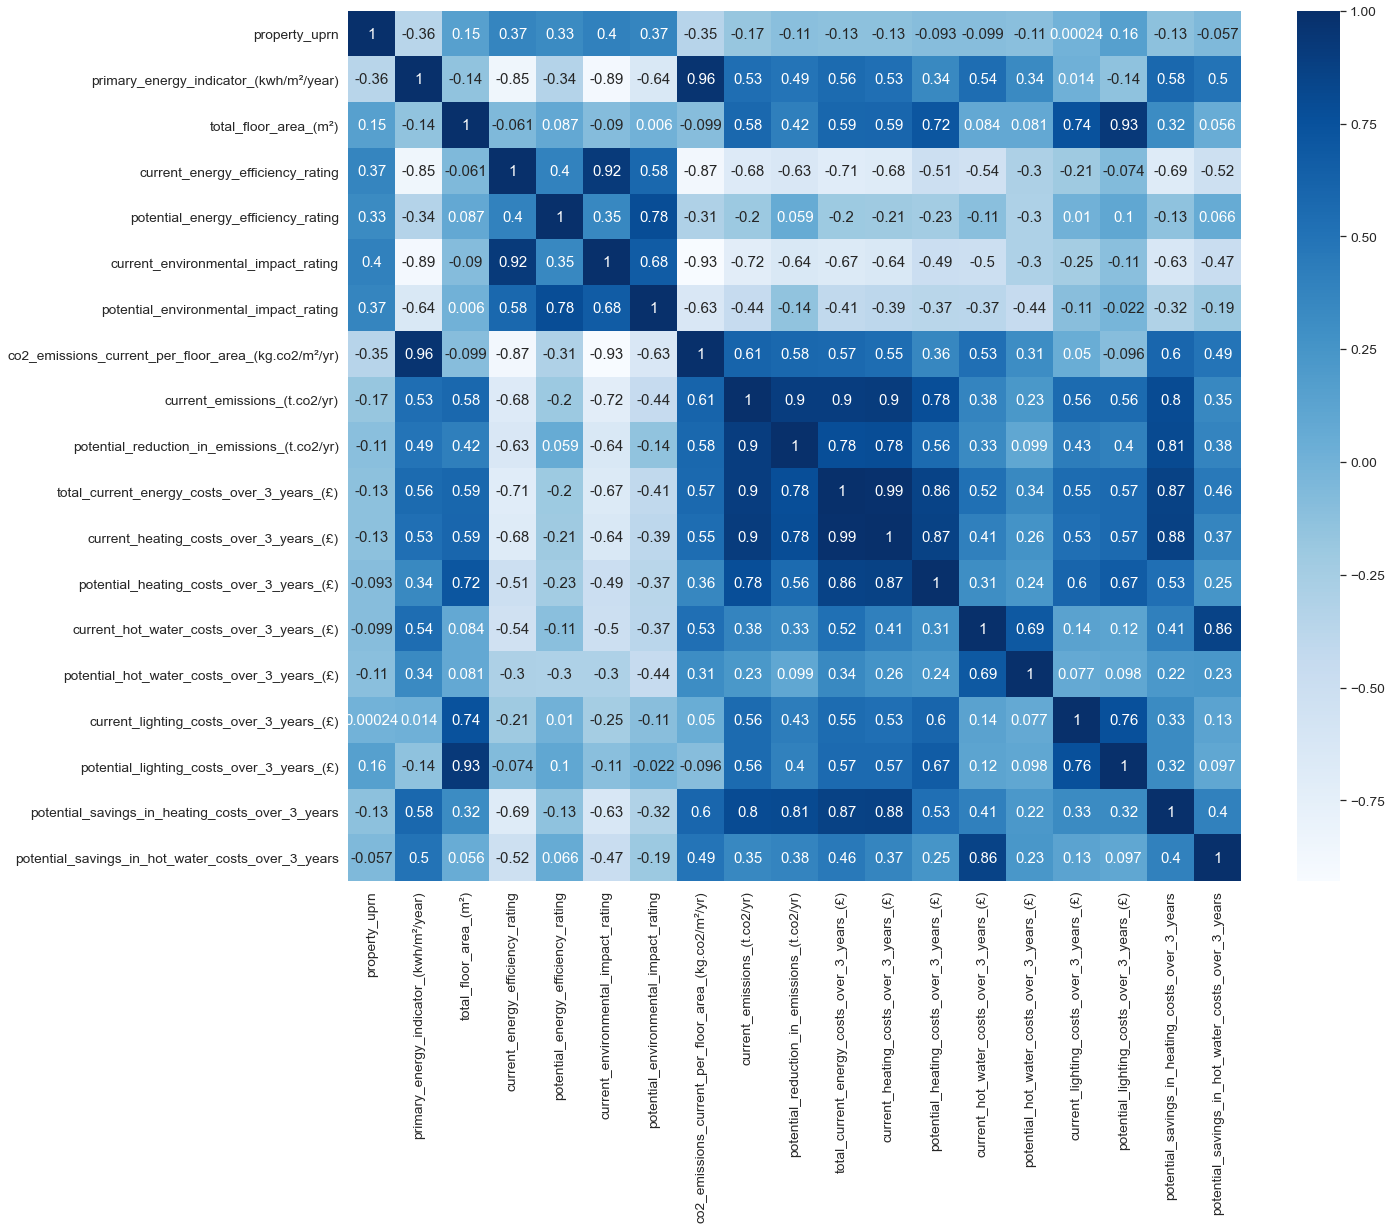

In [61]:
corr = df.corr(numeric_only=True)
# plot the heatmap
f, ax = plt.subplots(figsize = (20, 16))
sns.heatmap(corr, cmap='Blues', annot=True)
plt.show()

We start with identifying building criterias which have moderate to strong correlations for each type of costs.
<br><br>
Current heating costs over 3 years (£):
<ul>
    <li>Positive correlations with primary energy indicator (kwh/m²/year), total floor area (m²).</li>
    <li>Negative correlations with current energy efficiency rating, mainheat description, mainheat energy efficiency, mainheat environment efficiency.</li>
</ul>
<br>
Current hot water costs over 3 years (£):
<ul>
    <li>Positive correlations with primary energy indicator (kwh/m²/year), total floor area (m²)</li>
    <li>Negative correlations with current energy efficiency rating, hot water energy efficiency, 
                  hot water environment efficiency.</li>
</ul>
<br>
Current lighting costs over 3 years (£):
<ul>
    <li>Positive correlations with primary energy indicator (kwh/m²/year), total floor area (m²)</li>
    <li>Negative correlations with current energy efficiency rating, lighting description, lighting energy efficiency, lighting environment efficiency.</li>
</ul>
<br>
With the above information in mind, we built three separate Machine Learning Models to predict individual costs.<br><br>
Below is a breakdown on the model's performance on prediction on a scale of 0 to 1, 1 being the highest.

In [62]:
#--------------------------------  Data preparation for ML model ------------------------------#

In [63]:
# create separate dataset for ML model
df_heating = df[['primary_energy_indicator_(kwh/m²/year)', 'total_floor_area_(m²)',\
                 'current_energy_efficiency_rating', 'mainheat_description', 'mainheat_energy_eff',\
                 'mainheat_env_eff', 'current_heating_costs_over_3_years_(£)']].copy()

df_hotwater = df[['primary_energy_indicator_(kwh/m²/year)', 'total_floor_area_(m²)',\
                  'current_energy_efficiency_rating', 'hot_water_energy_eff', \
                  'hot_water_env_eff', 'current_hot_water_costs_over_3_years_(£)']].copy()

df_lighting = df[['primary_energy_indicator_(kwh/m²/year)', 'total_floor_area_(m²)',\
                  'current_energy_efficiency_rating', 'lighting_description', \
                  'lighting_energy_eff', 'lighting_env_eff', 'current_lighting_costs_over_3_years_(£)']].copy()

In [64]:
df_heating.dropna(inplace=True)
df_hotwater.dropna(inplace=True)
df_lighting.dropna(inplace=True)

In [65]:
#-------------------------------- feature engineering for ML model ------------------------------#

In [66]:
# split multiple main heat descriptions and efficiency ratings into separate records

df_heating['mainheat_description'] = df_heating['mainheat_description'].str.split("|")
df_heating['mainheat_energy_eff'] = df_heating['mainheat_energy_eff'].str.split("|")
df_heating['mainheat_env_eff'] = df_heating['mainheat_env_eff'].str.split("|")

df_heating = df_heating.explode(['mainheat_description', 'mainheat_energy_eff',\
       'mainheat_env_eff'])

df_heating['mainheat_description'] = df_heating['mainheat_description'].str.lower().str.strip()
df_heating['mainheat_energy_eff'] = df_heating['mainheat_energy_eff'].str.strip()
df_heating['mainheat_env_eff'] = df_heating['mainheat_env_eff'].str.strip()

In [67]:
# split multiple hot water descriptions and efficiency ratings into separate records

df_hotwater['hot_water_energy_eff'] = df_hotwater['hot_water_energy_eff'].str.split("|")
df_hotwater['hot_water_env_eff'] = df_hotwater['hot_water_env_eff'].str.split("|")

df_hotwater = df_hotwater.explode(['hot_water_energy_eff','hot_water_env_eff'])

df_hotwater['hot_water_energy_eff'] = df_hotwater['hot_water_energy_eff'].str.strip()
df_hotwater['hot_water_env_eff'] = df_hotwater['hot_water_env_eff'].str.strip()

In [68]:
# split multiple lighting descriptions and efficiency ratings into separate records

df_lighting['lighting_description'] = df_lighting['lighting_description'].str.split("|")
df_lighting['lighting_energy_eff'] = df_lighting['lighting_energy_eff'].str.split("|")
df_lighting['lighting_env_eff'] = df_lighting['lighting_env_eff'].str.split("|")

df_lighting = df_lighting.explode(['lighting_description', 'lighting_energy_eff',\
       'lighting_env_eff'])

df_lighting['lighting_description'] = df_lighting['lighting_description'].str.lower().str.strip()
df_lighting['lighting_energy_eff'] = df_lighting['lighting_energy_eff'].str.strip()
df_lighting['lighting_env_eff'] = df_lighting['lighting_env_eff'].str.strip()

In [69]:
# map energy and environment efficiency ratings from alphanumeric values to numeric values

df_heating['mainheat_energy_eff'] = df_heating['mainheat_energy_eff'].map(dict_efficiency)
df_heating['mainheat_env_eff'] = df_heating['mainheat_env_eff'].map(dict_efficiency)

df_hotwater['hot_water_energy_eff'] = df_hotwater['hot_water_energy_eff'].map(dict_efficiency)
df_hotwater['hot_water_env_eff'] = df_hotwater['hot_water_env_eff'].map(dict_efficiency)

df_lighting['lighting_energy_eff'] = df_lighting['lighting_energy_eff'].map(dict_efficiency)
df_lighting['lighting_env_eff'] = df_lighting['lighting_env_eff'].map(dict_efficiency)

In [70]:
# calculate average heating costs for each main heating description category
def heat_average(group):
    average = 'average_' + str(group[2][0])
    df_heating[average] = df_heating[group[0]].groupby(group[1])[group[2]].transform('mean')

rank_heat_costs = [['mainheat_description', 'current_heating_costs_over_3_years_(£)'], \
                   ['mainheat_description'], ['current_heating_costs_over_3_years_(£)']]
heat_average(rank_heat_costs)

In [71]:
# rank average heating costs across all main heating description category
heating_cost_average = ['average_current_heating_costs_over_3_years_(£)']
df_heating['rank_heating_cost'] = df_heating[heating_cost_average].rank(method='dense').astype(int)

In [72]:
# calculate average lighting costs for each lighting description category

def lighting_average(group):
    average = 'average_' + str(group[2][0])
    df_lighting[average] = df_lighting[group[0]].groupby(group[1])[group[2]].transform('mean')

rank_light_costs = [['lighting_description', 'current_lighting_costs_over_3_years_(£)'], \
                   ['lighting_description'], ['current_lighting_costs_over_3_years_(£)']]
lighting_average(rank_light_costs)

In [73]:
# rank average lighting costs across all lighting description category
lighting_cost_average = ['average_current_lighting_costs_over_3_years_(£)']
df_lighting['rank_lighting_cost'] = df_lighting[lighting_cost_average].rank(method='dense').astype(int)

In [74]:
# --------Algo. takes as input the characteristics of a building (except those related to costs)---------- # 
#----------------- outputs the total cost of energy of the building over a 3-year period ----------------- #

In [75]:
# evaluate candidate linreg models for best model, called by eval_models()
def train_model(model, df, num_features, target):
    features = num_features
    X = df[features]
    y = df[target]
    
    t = [('num', MinMaxScaler(), num_features)]
    col_transformer = ColumnTransformer(transformers=t)
    
    # define the data preparation and modeling pipeline
    pipeline = Pipeline(steps=[('prep',col_transformer), ('m', model)])
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # evaluate the pipeline using cross validation and calculate MAE
    scores = cross_val_score(pipeline, X, y.values.ravel(), scoring='r2', cv=cv)
   
    # summarize the model performance
    print("R2 score: %.3f" % (np.mean(scores)))

In [76]:
# evaluate candidate linreg models for best model
def eval_models(df, num_features, target):
    
    linear_clf = LinearRegression()
    train_model(linear_clf, df, num_features, target)

    dt_clf = DecisionTreeRegressor()
    train_model(dt_clf, df, num_features, target)

    rf_clf = RandomForestRegressor()
    train_model(rf_clf, df, num_features, target)

In [77]:
heat_num_features = ['primary_energy_indicator_(kwh/m²/year)', 'total_floor_area_(m²)',\
                     'current_energy_efficiency_rating', 'mainheat_energy_eff', \
                     'mainheat_env_eff', 'rank_heating_cost']
heat_target = ['current_heating_costs_over_3_years_(£)']

df_hotwater.dropna(inplace=True)

hotwater_num_features = ['primary_energy_indicator_(kwh/m²/year)', 'total_floor_area_(m²)',\
                         'current_energy_efficiency_rating', 'hot_water_energy_eff', 'hot_water_env_eff']
hotwater_target = ['current_hot_water_costs_over_3_years_(£)']

lighting_num_features = ['primary_energy_indicator_(kwh/m²/year)', 'total_floor_area_(m²)',\
                         'current_energy_efficiency_rating', 'lighting_energy_eff', 'lighting_env_eff', 'rank_lighting_cost']
lighting_target = ['current_lighting_costs_over_3_years_(£)']

In [78]:
# Uncomment for best model evaluation. Note that this takes some time to run

# print("Evaluate best model for heating")
# eval_models(df_heating, heat_num_features, heat_target)

# =================================================================
# Results from test, do not uncomment this part
# =================================================================
# Results:
# Evaluate best model for heating
# R2 score: 0.794
# R2 score: 0.916
# R2 score: 0.955 (Random forest)

In [79]:
# Uncomment for best model evaluation. Note that this takes some time to run

# print("Evaluate best model for hot water")
# eval_models(df_hotwater, hotwater_num_features, hotwater_target)

# =================================================================
# Results from test, do not uncomment this part
# =================================================================
# Evaluate best model for hot water
# R2 score: 0.758
# R2 score: 0.727
# R2 score: 0.843 (Random Forest)

In [80]:
# Uncomment for best model evaluation. Note that this takes some time to run

# print("Evaluate best model for lighting")
# eval_models(df_lighting, lighting_num_features, lighting_target)

# =================================================================
# Results from test, do not uncomment this part
# =================================================================
# Evaluate best model for lighting
# R2 score: 0.885
# R2 score: 0.976
# R2 score: 0.985

In [81]:
# Hyperparameter tuning for best candidate model: Random Forest Regressor
# Uncomment for hyperparameter tuning. Note that this takes substantial time to run

# def tuneModels(estimator, param_grid, X, y):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
#     t = [('num', MinMaxScaler(), X.columns)]
#     col_transformer = ColumnTransformer(transformers=t)
    
#     pipeline = Pipeline(steps=[('prep',col_transformer), ('m', estimator)])
  
#     model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
#     model.fit(X_train,y_train.values.ravel())
#     print('Best Score: ', model.best_score_) 
#     print('Best Parameters: ', model.best_params_) 

In [82]:
# rf_reg = RandomForestRegressor()
# param_grid_rf = {'m__n_estimators': [100, 150, 250], 
#                  'm__max_depth': [5, 10, 15],
#                 "m__min_samples_split" : [2,4,8]}

# print("Hyperparameter tuning for Random Forest model:\n")

# print("Heating=====\n")
# X = df_heating[heat_num_features]
# y = df_heating[heat_target]
# tuneModels(rf_reg, param_grid_rf, X, y)

# print("Hot Water=====\n")
# X = df_hotwater[hotwater_num_features]
# y = df_hotwater[hotwater_target]
# tuneModels(rf_reg, param_grid_rf, X, y)

# print("Lighting=====\n")
# X = df_lighting[lighting_num_features]
# y = df_lighting[lighting_target]
# tuneModels(rf_reg, param_grid_rf, X, y)

# ===================================================================================
# Hyperparameter tuning for Random Forest model (results), do not uncomment this part
# ===================================================================================

# Heating=====

# Best Score:  0.9545040007601606
# Best Parameters:  {'m__max_depth': 15, 'm__min_samples_split': 4, 'm__n_estimators': 250}
    
# Hot Water=====

# Best Score:  0.8551027385247701
# Best Parameters:  {'m__max_depth': 15, 'm__min_samples_split': 8, 'm__n_estimators': 250}
    
# Lighting=====

# Best Score:  0.9845158473789464
# Best Parameters:  {'m__max_depth': 15, 'm__min_samples_split': 4, 'm__n_estimators': 250}


In [83]:
def heating_model():
    rf_final = RandomForestRegressor(max_depth=15, min_samples_split=4, n_estimators=250)
    
    X = df_heating[heat_num_features]
    y = df_heating[heat_target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    t = [('num', MinMaxScaler(), X.columns)]
    col_transformer = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transformer), ('m', rf_final)])
    pipeline.fit(X_train, y_train.values.ravel())
    pred = pipeline.predict(X_test)
    return pipeline.score(X_test, y_test)

In [84]:
def hotwater_model():
    rf_final = RandomForestRegressor(max_depth=15, min_samples_split=8, n_estimators=250)
    
    X = df_hotwater[hotwater_num_features]
    y = df_hotwater[hotwater_target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    t = [('num', MinMaxScaler(), X.columns)]
    col_transformer = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transformer), ('m', rf_final)])
    pipeline.fit(X_train, y_train.values.ravel())
    pred = pipeline.predict(X_test)
    return pipeline.score(X_test, y_test)

In [85]:
def lighting_model():
    rf_final = RandomForestRegressor(max_depth=15, min_samples_split=4, n_estimators=250)
    
    X = df_lighting[lighting_num_features]
    y = df_lighting[lighting_target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    t = [('num', MinMaxScaler(), X.columns)]
    col_transformer = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transformer), ('m', rf_final)])
    pipeline.fit(X_train, y_train.values.ravel())
    pred = pipeline.predict(X_test)
    return pipeline.score(X_test, y_test)

In [86]:
score = heating_model()
print("Model performance for predicting current heating costs over 3 years: ", score)

Model performance for predicting current heating costs over 3 years:  0.9418734153228135


In [87]:
score = hotwater_model()
print("Model performance for predicting current hot water costs over 3 years: ", score)

Model performance for predicting current hot water costs over 3 years:  0.8505996402862955


In [88]:
score = lighting_model()
print("Model performance for predicting current lighting costs over 3 years: ", score)

Model performance for predicting current lighting costs over 3 years:  0.9851809581929017


### Summary

The energy performances of Scottish towns tells us how well some of them have done so far, and how some others carry great potential for better energy performance if they carry out improvement suggestions. Rankings such as top 10 towns in potential savings in various costs (heating, hot water) show us how improvements could reduce costs by a huge amount over 3 years, for example, Bonawe and East Dunbartonshire could save all together over 22000 pounds in 3 years potentially in heating, that is a huge amount of costs and imagine how these savings could be put towards other improvements locally.

The wall and roof materials tell us another story on materials that are more environmental-friendly are also easyier on the pocket, and it pays to invest in greener materials for building improvements and constructions likewise. This in particular has never been more obvious as we looked at the correlations between a building's construction age and how their associated energy performance looked like overall.

### Final Thoughts
We hope that you find our analysis very insightful. There are a few recommendations for suggestions of improvement and future work:

<ol>
    <li> The wall and roof recommender model can be extended into a online energy performance improvement recommendations system, which allows input for various building materials, and then outputs recommendations on materials that perform better. </li>
    <li> The energy costs prediction models can also be combined into the energy performance improvement system as above, which allows input for various energy consumption sources (heating, hot water, lighting) to predict total costs for users. </li>
    <li> The combination of the two suggestions above, could lead to a user feature which not only outputs recommendations on materials that perform better, but also calculate the potential total energy costs based on such recommendations. </li>
    </ol>